In [ ]:
import scipy as sp
import numpy as np
from scipy import stats
from scipy.special import logsumexp
from numpy import seterr

class PHMMs:
    def __init__(self,init_ditri,init_trans_matrix,set_paramPoisson,ob_seqs,epsi):
        seterr(divide='ignore')
        self.nber_states=len(init_ditri)
        self.log_init_ditri=np.log(init_ditri)
        self.log_init_trans_matrix=np.log(init_trans_matrix)
        self.set_paramPoisson=np.array(set_paramPoisson)
        self.epsi=epsi
        self.ob_seqs=ob_seqs
        seterr(divide='warn')

    def log_prob_Poisson(self, mean, val):
        return stats.poisson(mean).logpmf(val)


    def matrix_alpha(self):
        seterr(divide='ignore')
        log_bi_o1=[self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[0]) for i in range(self.nber_states) ]
        log_pibi_o1=np.add(self.log_init_ditri,log_bi_o1)
        alpha_matrix=[log_pibi_o1]
        for i in range(1,len(self.ob_seqs)):
            log_alpha_i=[]
            for j in range(self.nber_states):
                log_alpha_prev=alpha_matrix[-1]
                log_prev_mulA=np.add(log_alpha_prev,self.log_init_trans_matrix[::,j])
                sumlog=logsumexp(log_prev_mulA)
                alpha_ij=sumlog+self.log_prob_Poisson(self.set_paramPoisson[j],self.ob_seqs[i])
                log_alpha_i.append(alpha_ij)
            alpha_matrix.append(log_alpha_i)
        alpha_T=alpha_matrix[-1]
        seterr(divide='warn')
        return np.array(alpha_matrix)

    def matrix_beta(self):
        seterr(divide='ignore')
        log_b_oT=[0 for i in range(self.nber_states)]
        beta_matrix=[log_b_oT]
        for i in range(len(self.ob_seqs)-2,-1,-1):#i o day la t
            log_beta_i=[]
            for j in range(self.nber_states):#j ow day la i trong cong thuc
                log_beta_prev=beta_matrix[-1]
                log_prev_mulA=np.add(self.log_init_trans_matrix[j],log_beta_prev)
                emit_prob=[self.log_prob_Poisson(self.set_paramPoisson[k],self.ob_seqs[i+1]) for k in range(self.nber_states)]
                log_prev_mulA1=np.add(log_prev_mulA,emit_prob)
                sumlog=logsumexp(log_prev_mulA1)
                beta_ij=sumlog
                log_beta_i.append(beta_ij)
            beta_matrix.append(log_beta_i)
        beta_matrix.reverse()
        seterr(divide='warn')
        return np.array(beta_matrix)
    def check(self):#P(O|lambda)=prob_O
        temp1=self.matrix_alpha()
        temp2=self.matrix_beta()
        prob_O_directly=logsumexp(temp1[-1])
        return prob_O_directly
    def vterbi(self):
        v_n=[0.0 for _ in range(self.nber_states)]
        vlst=[v_n]
        wlst=[]
        for i in range(len(self.ob_seqs)-1,0,-1):
            v_i = []
            w_i = []
            for j in range(self.nber_states):
                all_v_ij = []
                for k in range(self.nber_states):
                    temp = self.log_init_trans_matrix[j,k] + self.log_prob_Poisson(self.set_paramPoisson[k], self.ob_seqs[i])
                    temp += vlst[-1][k]
                    all_v_ij.append(temp)
                v_i.append(max(all_v_ij))
                w_i.append(np.argmax(all_v_ij))
            vlst.append(v_i)
            wlst.append(w_i)
        wlst.reverse()
        first_prob = [self.log_prob_Poisson(self.set_paramPoisson[i], self.ob_seqs[0]) for i in range(self.nber_states)]
        first_prob = np.add(first_prob, self.log_init_ditri)
        first_prob=np.add(first_prob, vlst[-1])
        h_1 = np.argmax(first_prob)
        statelst = [h_1]
        print(wlst)
        for i in range(len(wlst)):
            statelst.append(wlst[i][statelst[-1]])
        return statelst
    
    
    def matrix_emission(self):
        b=np.zeros((len(self.ob_seqs),self.nber_states))
        for t in range(len(self.ob_seqs)):
            for i in range(self.nber_states):
                b[t][i]=self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[t])
        return np.exp(b)
  
  
    def numerator_update_trans(self,i,j,temp1,temp2,temp3):
    
        T=len(self.ob_seqs)
        a1=temp1[0:(T-1),i]
        a2=temp2[1:T,j]
        a3=np.add(a1,a2)
        a5=temp3[1:T,j]
        a4=np.add(a3,a5)
        res=logsumexp(a4)
        return res
    def denominator_update_trans(self,i,temp1,temp2):
        
        T=len(self.ob_seqs)
        a1=temp1[0:(T-1),i]
        a2=temp2[0:(T-1),i]
        res=np.add(a1,a2)
        resu=logsumexp(res)
        return resu

    def denominator_update_lambda(self,i,temp1,temp2):

        T=len(self.ob_seqs)
        a1=temp1[:,i]
        a2=temp2[:,i]
        res=np.add(a1,a2)
        resu=logsumexp(res)
        return resu
    def numerator_update_lambda(self,i,temp1,temp2):
        
        T=len(self.ob_seqs)
        a1=temp1[:,i]
        a2=temp2[:,i]
        res=np.add(a1,a2)
        a3=np.log(self.ob_seqs)
        resu=np.add(res,a3)
        result=logsumexp(resu)
        return result

    def update_init_ditri(self,temp1,temp2):
        
        a1=temp1[0]
        a2=temp2[0]
        res=np.add(a1,a2)
        L_T=logsumexp(res)
        result=list(map(lambda x:x-L_T,res))
        return result

        



    def Baum_Welch(self,max_iter=200):
        T=len(self.ob_seqs)
        N=self.nber_states
    
        for itere in range(max_iter):
            alpha_matrix=self.matrix_alpha()
            beta_matrix=self.matrix_beta()
            emission_matrix=np.log(self.matrix_emission())
            log_pre_L_T=self.check()
            new_trans=np.zeros((N,N))
            new_param=[0 for _ in range(N)]
            #update trans_matrix
            for i in range(N):
                for j in range(N):
                    new_trans[i,j]=self.log_init_trans_matrix[i,j]+self.numerator_update_trans(i,j,alpha_matrix,beta_matrix,emission_matrix)- self.denominator_update_trans(i,alpha_matrix,beta_matrix)
            #update set_param:
            print("-----lambda------")
            for i in range(N):
                new_param[i]=np.exp(self.numerator_update_lambda(i,alpha_matrix,beta_matrix)-self.denominator_update_lambda(i,alpha_matrix,beta_matrix))
            print("lambda o vong lap",itere,new_param)
            #update init_ditri
            print("----init-----")
            self.log_init_ditri=self.update_init_ditri(alpha_matrix,beta_matrix)
            print("init_ditri update:",self.log_init_ditri)
            print("--------------")
            self.set_paramPoisson=new_param
            self.log_init_trans_matrix=new_trans
            print("ma trix ms cap nhat:\n",np.exp(self.log_init_trans_matrix))
            log_current_LT=self.check()
            print("different giữa 2 cái log:",log_current_LT-log_pre_L_T)
            if 0<log_current_LT-log_pre_L_T<1e-10:
                break

    def AIC(self):
        return (2*(self.nber_states**2) - 2*self.check())

    def BIC(self):
        return ((self.nber_states**2)*np.log(len(self.ob_seqs)) - 2*self.check())
#APPLICATION WITH DATASET count the number of vehicle go through a part of particular road
theta = np.array([[0.4, 0.3,0.15,0.15],[0.25, 0.25,0.25,0.25],[0.1,0.5,0.3,0.1],[0.25,0.5,0.1,0.15]])
delta = np.array([0.4, 0.2,0.2,0.2])
lambdas = np.array([500,200,300,250])
epsi1=0.0001
seqs=np.array([ 835,  819,  771,  565,  346,  135,  109,  160,  244,  555,  627,
        724,  803,  896,  915,  858,  856,  698,  998,  993, 1107, 1073,
       1009,  977,  958,  860,  742,  621,  409,  170,  182,  266,  331,
        486,  554,  675,  748,  702,  855,  888,  919,  878,  903,  851,
        832,  372,  270,  157,  153,  136,  171,  244,  478,  803,  908,
        951,  911,  864,  849,  924,  920,  916,  994,  972,  947,  945,
        914,  793,  694,  554,  361,  215,  181,  122,  176,  260,  568,
        972, 1005, 1068,  996, 1049, 1121, 1087,  960, 1088, 1090,  866,
       1035, 1147, 1047,  873,  747,  627,  444,  245,  165,  144,  179,
        324,  576,  961,  994, 1032,    0,  802,  896, 1015,  894,  943,
       1107, 1103, 1109, 1160, 1003,  850,  763,  672,  503,  292,  207,
        162,  189,  304,  509,  929,  936,  968,  983,  987, 1018,  965,
        948,  925, 1081, 1037, 1128, 1267, 1093,  966,  843,  867,  843,
        633,  426,  367,  245,  268,  510,  573,  893,  883,  992,  997,
        935, 1065, 1002, 1021, 1121,  973, 1178, 1375, 1362, 1231, 1055,
        916,  963,  992,  787,  545,  231,  190,  287,  411,  527,  682,
        768,  909,  968,  990, 1026,  919, 1083, 1095, 1165, 1378, 1389,
       1359, 1214, 1265, 1237, 1110,  900,  652,  316,  161,  237,  273,
        379,  506,  613,  401,  776,  844,  787,  778,  875,  918,  981,
       1039,  968,  780,  643,  499,  412,  289])
test=PHMMs(delta,theta,lambdas,seqs,epsi1)
print(test.check())
test.Baum_Welch()
print("--------")
print("pp ban dau",np.exp(test.log_init_ditri))
print("mtxsc",np.exp(test.log_init_trans_matrix))
print("lambda",test.set_paramPoisson)
print(test.check())
print("----------")
print("AIC:",test.AIC())
print("BIC:",test.BIC())


-27073.605531202196


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: divide by zero encountered in log


tu va mau tuong ung voi  0 0 tu: -27067.614028563592 mau: -27068.4638276775
tu va mau tuong ung voi  0 1 tu: -27071.620052087852 mau: -27068.4638276775
tu va mau tuong ung voi  0 2 tu: -27069.77632729897 mau: -27068.4638276775
tu va mau tuong ung voi  0 3 tu: -27071.060210756135 mau: -27068.4638276775
tu va mau tuong ung voi  1 0 tu: -27072.195910515024 mau: -27070.49953706365
tu va mau tuong ung voi  1 1 tu: -27069.634717946537 mau: -27070.49953706365
tu va mau tuong ung voi  1 2 tu: -27071.021859506778 mau: -27070.49953706365
tu va mau tuong ung voi  1 3 tu: -27070.66330992521 mau: -27070.49953706365
tu va mau tuong ung voi  2 0 tu: -27069.713152073076 mau: -27071.08108796899
tu va mau tuong ung voi  2 1 tu: -27071.39441425806 mau: -27071.08108796899
tu va mau tuong ung voi  2 2 tu: -27071.92072855901 mau: -27071.08108796899
tu va mau tuong ung voi  2 3 tu: -27070.96587712742 mau: -27071.08108796899
tu va mau tuong ung voi  3 0 tu: -27070.8145132482 mau: -27071.38874213413
tu va mau 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: RuntimeWarning: divide by zero encountered in log


different giữa 2 cái log: 22573.03497020019
tu va mau tuong ung voi  0 0 tu: -4495.55459244165 mau: -4495.539462249398
tu va mau tuong ung voi  0 1 tu: -4496.210363787323 mau: -4495.539462249398
tu va mau tuong ung voi  0 2 tu: -4494.963055459389 mau: -4495.539462249398
tu va mau tuong ung voi  0 3 tu: -4505.260742579238 mau: -4495.539462249398
tu va mau tuong ung voi  1 0 tu: -4497.487893189461 mau: -4497.556131676075
tu va mau tuong ung voi  1 1 tu: -4497.617270115023 mau: -4497.556131676075
tu va mau tuong ung voi  1 2 tu: -4497.795743794308 mau: -4497.556131676075
tu va mau tuong ung voi  1 3 tu: -4497.294148684427 mau: -4497.556131676075
tu va mau tuong ung voi  2 0 tu: -4497.444610893222 mau: -4497.231515936844
tu va mau tuong ung voi  2 1 tu: -4498.350651448144 mau: -4497.231515936844
tu va mau tuong ung voi  2 2 tu: -4496.229244073399 mau: -4497.231515936844
tu va mau tuong ung voi  2 3 tu: -4496.60332834496 mau: -4497.231515936844
tu va mau tuong ung voi  3 0 tu: -4499.7067047

In [ ]:
import scipy as sp
import numpy as np
from scipy import stats
from scipy.special import logsumexp
from numpy import seterr

class PHMMs:
    def __init__(self,init_ditri,init_trans_matrix,set_paramPoisson,ob_seqs,epsi):
        seterr(divide='ignore')
        self.nber_states=len(init_ditri)
        self.log_init_ditri=np.log(init_ditri)
        self.log_init_trans_matrix=np.log(init_trans_matrix)
        self.set_paramPoisson=np.array(set_paramPoisson)
        self.epsi=epsi
        self.ob_seqs=ob_seqs
        seterr(divide='warn')

    def log_prob_Poisson(self, mean, val):
        return stats.poisson(mean).logpmf(val)


    def matrix_alpha(self):#output la matrix alpha voi hang la tu 0 den N-1, cot la tu 0 den T-1
        seterr(divide='ignore')
        log_bi_o1=[self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[0]) for i in range(self.nber_states) ]
        log_pibi_o1=np.add(self.log_init_ditri,log_bi_o1)
        alpha_matrix=[log_pibi_o1]
        for i in range(1,len(self.ob_seqs)):
            log_alpha_i=[]
            for j in range(self.nber_states):
                log_alpha_prev=alpha_matrix[-1]
                log_prev_mulA=np.add(log_alpha_prev,self.log_init_trans_matrix[::,j])
                sumlog=logsumexp(log_prev_mulA)
                alpha_ij=sumlog+self.log_prob_Poisson(self.set_paramPoisson[j],self.ob_seqs[i])
                log_alpha_i.append(alpha_ij)
            alpha_matrix.append(log_alpha_i)
        alpha_T=alpha_matrix[-1]
        seterr(divide='warn')
        return np.array(alpha_matrix)

    def matrix_beta(self):#output laf ma tran beta voi beta[i] la tai t=i, 1 hang tu 1 den N(nberstates)
        seterr(divide='ignore')
        #log_b_oT=[self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[-1]) for i in range(self.nber_states) ]
        log_b_oT=[0 for i in range(self.nber_states)]
        beta_matrix=[log_b_oT]
        for i in range(len(self.ob_seqs)-2,-1,-1):#i o day la t
            log_beta_i=[]
            for j in range(self.nber_states):#j ow day la i trong cong thuc
                log_beta_prev=beta_matrix[-1]
                log_prev_mulA=np.add(self.log_init_trans_matrix[j],log_beta_prev)
                emit_prob=[self.log_prob_Poisson(self.set_paramPoisson[k],self.ob_seqs[i+1]) for k in range(self.nber_states)]
                log_prev_mulA1=np.add(log_prev_mulA,emit_prob)
                sumlog=logsumexp(log_prev_mulA1)
                beta_ij=sumlog
                log_beta_i.append(beta_ij)
            beta_matrix.append(log_beta_i)
        beta_matrix.reverse()
        seterr(divide='warn')
        return np.array(beta_matrix)
    def check(self):#P(O|lambda)=prob_O
        temp1=self.matrix_alpha()
        temp2=self.matrix_beta()
        prob_O_directly=logsumexp(temp1[-1])
        return prob_O_directly
    def vterbi(self):
        v_n=[0.0 for _ in range(self.nber_states)]
        vlst=[v_n]
        wlst=[]
        for i in range(len(self.ob_seqs)-1,0,-1):
            v_i = []
            w_i = []
            for j in range(self.nber_states):
                all_v_ij = []
                for k in range(self.nber_states):
                    temp = self.log_init_trans_matrix[j,k] + self.log_prob_Poisson(self.set_paramPoisson[k], self.ob_seqs[i])
                    temp += vlst[-1][k]
                    all_v_ij.append(temp)
                v_i.append(max(all_v_ij))
                w_i.append(np.argmax(all_v_ij))
            vlst.append(v_i)
            wlst.append(w_i)
        wlst.reverse()
        first_prob = [self.log_prob_Poisson(self.set_paramPoisson[i], self.ob_seqs[0]) for i in range(self.nber_states)]
        first_prob = np.add(first_prob, self.log_init_ditri)
        first_prob=np.add(first_prob, vlst[-1])
        h_1 = np.argmax(first_prob)
        statelst = [h_1]
        print(wlst)
        for i in range(len(wlst)):
            statelst.append(wlst[i][statelst[-1]])
        return statelst
    
    
    def matrix_emission(self):
        b=np.zeros((len(self.ob_seqs),self.nber_states))
        for t in range(len(self.ob_seqs)):
            for i in range(self.nber_states):
                b[t][i]=self.log_prob_Poisson(self.set_paramPoisson[i],self.ob_seqs[t])
        return np.exp(b)
  
  #tu day xuong la co cho sai
    def numerator_update_trans(self,i,j,temp1,temp2,temp3):
    
        T=len(self.ob_seqs)
        a1=temp1[0:(T-1),i]
        a2=temp2[1:T,j]
        a3=np.add(a1,a2)
        a5=temp3[1:T,j]
        a4=np.add(a3,a5)
        res=logsumexp(a4)
        return res
    def denominator_update_trans(self,i,temp1,temp2):
        
        T=len(self.ob_seqs)
        a1=temp1[0:(T-1),i]
        a2=temp2[0:(T-1),i]
        res=np.add(a1,a2)
        resu=logsumexp(res)
        return resu

    def denominator_update_lambda(self,i,temp1,temp2):

        T=len(self.ob_seqs)
        a1=temp1[:,i]
        a2=temp2[:,i]
        res=np.add(a1,a2)
        resu=logsumexp(res)
        return resu
    def numerator_update_lambda(self,i,temp1,temp2):
        
        T=len(self.ob_seqs)
        a1=temp1[:,i]
        a2=temp2[:,i]
        res=np.add(a1,a2)
        a3=np.log(self.ob_seqs)
        resu=np.add(res,a3)
        result=logsumexp(resu)
        return result

    def update_init_ditri(self,temp1,temp2):
        
        a1=temp1[0]
        a2=temp2[0]
        res=np.add(a1,a2)
        L_T=logsumexp(res)
        result=list(map(lambda x:x-L_T,res))
        return result

        



    def Baum_Welch(self,max_iter=200):
        T=len(self.ob_seqs)
        N=self.nber_states
    
        for itere in range(max_iter):
            alpha_matrix=self.matrix_alpha()
            beta_matrix=self.matrix_beta()
            emission_matrix=np.log(self.matrix_emission())
            log_pre_L_T=self.check()
            new_trans=np.zeros((N,N))
            new_param=[0 for _ in range(N)]
            #update trans_matrix
            for i in range(N):
                for j in range(N):
                    print("tu va mau tuong ung voi ",i,j,"tu:",self.numerator_update_trans(i,j,alpha_matrix,beta_matrix,emission_matrix),"mau:",self.denominator_update_trans(i,alpha_matrix,beta_matrix))
                    new_trans[i,j]=self.log_init_trans_matrix[i,j]+self.numerator_update_trans(i,j,alpha_matrix,beta_matrix,emission_matrix)- self.denominator_update_trans(i,alpha_matrix,beta_matrix)
            #update set_param:
            print("-----lambda------")
            for i in range(N):
                print("tu va mau cua  thu",i,"tu: ",self.numerator_update_lambda(i,alpha_matrix,beta_matrix),"mau :",self.denominator_update_lambda(i,alpha_matrix,beta_matrix))
                new_param[i]=np.exp(self.numerator_update_lambda(i,alpha_matrix,beta_matrix)-self.denominator_update_lambda(i,alpha_matrix,beta_matrix))
            print("lambda o vong lap",itere,new_param)
            #update init_ditri
            print("----init-----")
            self.log_init_ditri=self.update_init_ditri(alpha_matrix,beta_matrix)
            print("init_ditri update:",self.log_init_ditri)
            print("--------------")
            self.set_paramPoisson=new_param
            self.log_init_trans_matrix=new_trans
            print("ma trix ms capj nhat:\n",np.exp(self.log_init_trans_matrix))
            log_current_LT=self.check()
            print("different giữa 2 cái log:",log_current_LT-log_pre_L_T)
            if 0<log_current_LT-log_pre_L_T<1e-10:
                break

    def AIC(self):
        return (2*(self.nber_states**2) - 2*self.check())

    def BIC(self):
        return ((self.nber_states**2)*np.log(len(self.ob_seqs)) - 2*self.check())
#APPLICATION WITH DATASET count the number of vehicle go through a part of particular road
theta = np.array([[0.4, 0.3,0.15,0.15],[0.25, 0.25,0.25,0.25],[0.1,0.5,0.3,0.1],[0.25,0.5,0.1,0.15]])
delta = np.array([0.4, 0.2,0.2,0.2])
lambdas = np.array([500,200,300,250])
epsi1=0.0001
#seqs=np.array([0, 3, 1, 1, 6, 4, 0, 2, 5, 0, 0, 4, 6, 7, 6, 0, 2, 1, 2, 6, 0, 0, 1, 6, 5, 7, 3, 3, 6, 0, 6, 2, 1, 7, 7, 0, 5, 1, 7, 3, 0, 12, 1, 4, 2, 1, 1, 1, 1, 3, 5, 0, 5, 2, 1, 2, 4, 3, 1, 1, 1, 3, 5, 1, 5, 0, 0, 0, 9, 3, 0, 5, 6, 3, 4, 3, 5, 0, 2, 2, 0, 9, 5, 4, 8, 3, 2, 1, 9, 1, 8, 5, 5, 9, 8, 5, 3, 2, 7, 0])
#seqs=[2,1,3]
seqs=np.array([ 835,  819,  771,  565,  346,  135,  109,  160,  244,  555,  627,
        724,  803,  896,  915,  858,  856,  698,  998,  993, 1107, 1073,
       1009,  977,  958,  860,  742,  621,  409,  170,  182,  266,  331,
        486,  554,  675,  748,  702,  855,  888,  919,  878,  903,  851,
        832,  372,  270,  157,  153,  136,  171,  244,  478,  803,  908,
        951,  911,  864,  849,  924,  920,  916,  994,  972,  947,  945,
        914,  793,  694,  554,  361,  215,  181,  122,  176,  260,  568,
        972, 1005, 1068,  996, 1049, 1121, 1087,  960, 1088, 1090,  866,
       1035, 1147, 1047,  873,  747,  627,  444,  245,  165,  144,  179,
        324,  576,  961,  994, 1032,    0,  802,  896, 1015,  894,  943,
       1107, 1103, 1109, 1160, 1003,  850,  763,  672,  503,  292,  207,
        162,  189,  304,  509,  929,  936,  968,  983,  987, 1018,  965,
        948,  925, 1081, 1037, 1128, 1267, 1093,  966,  843,  867,  843,
        633,  426,  367,  245,  268,  510,  573,  893,  883,  992,  997,
        935, 1065, 1002, 1021, 1121,  973, 1178, 1375, 1362, 1231, 1055,
        916,  963,  992,  787,  545,  231,  190,  287,  411,  527,  682,
        768,  909,  968,  990, 1026,  919, 1083, 1095, 1165, 1378, 1389,
       1359, 1214, 1265, 1237, 1110,  900,  652,  316,  161,  237,  273,
        379,  506,  613,  401,  776,  844,  787,  778,  875,  918,  981,
       1039,  968,  780,  643,  499,  412,  289])
test=PHMMs(delta,theta,lambdas,seqs,epsi1)
print(test.check())
test.Baum_Welch()
print("--------")
print("pp ban dau",np.exp(test.log_init_ditri))
print("mtxsc",np.exp(test.log_init_trans_matrix))
print("lambda",test.set_paramPoisson)
print(test.check())
print("----------")
print("AIC:",test.AIC())
print("BIC:",test.BIC())




    



In [ ]:
statst=test.vterbi()

[[0, 0, 0, 2], [2, 0, 2, 2], [2, 3, 2, 2], [3, 3, 3, 3], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [3, 3, 3, 3], [2, 3, 2, 2], [2, 2, 2, 2], [2, 0, 2, 2], [2, 0, 2, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [2, 0, 2, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [2, 0, 2, 2], [2, 2, 2, 2], [3, 3, 3, 3], [1, 1, 3, 1], [1, 1, 3, 1], [3, 3, 3, 3], [3, 3, 3, 3], [2, 3, 2, 2], [2, 3, 2, 2], [2, 0, 2, 2], [2, 0, 2, 2], [2, 0, 2, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [3, 3, 3, 3], [3, 3, 3, 3], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 3, 1], [3, 3, 3, 3], [2, 3, 2, 2], [2, 0, 2, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [0, 0, 0, 2], [2, 0, 2, 2], [2, 0, 2, 2], [2, 3, 2, 2], [3, 3, 3, 3], [1, 1, 3, 1], [1, 1

In [ ]:
def generate_graph_data(state_sequence, rate_vector):
    expected_mean = []
    for state in state_sequence:
        expected_mean.append(rate_vector[state])
    return expected_mean

In [ ]:
expected_mean = generate_graph_data(state_sequence=statst, rate_vector=test.set_paramPoisson)

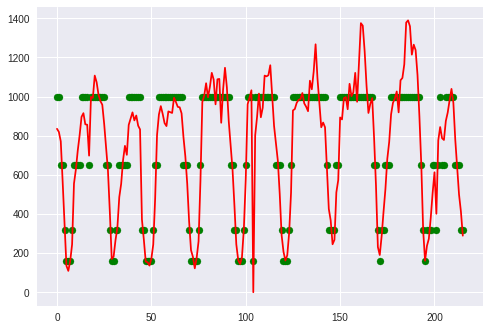

In [ ]:
import matplotlib.pyplot as plt
time = list(range(len(test.ob_seqs)))
plt.style.use('seaborn')
# plt.style.use('classic')
plt.plot(time, test.ob_seqs, color="r")
plt.scatter(time, expected_mean, c="g")
plt.savefig('test.png',dpi=600)